In [28]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import itertools
from time import time
import fasttext
from sklearn import preprocessing
from keras.utils import np_utils
from keras.layers import Dense, Embedding, Input
from keras.layers import Dropout, MaxPooling1D, Conv1D, Flatten, LSTM
from keras.models import Model
from keras.preprocessing import text, sequence
from nn_utils import TrainingHistory

Using TensorFlow backend.


In [2]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
print(str(list_dir))
nbs = []
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
    nbs.append(str(len(files)))
print(str(nbs))
#x = np.array(x)
#y = np.array(y)

['Advertisement', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
['230', '599', '431', '567', '620', '188', '201', '265', '120', '261']


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [12]:
for i in range(x.shape[0]):
    x[i] = x[i].replace('\n', ' ')
with open('tobacco_nolabel.txt', 'w') as f:
    for i in x:
        f.write(i + '\n')

In [5]:
with open('tobacco_train.txt', 'w') as f:
    for i in range(x_train.shape[0]):
        line = x_train[i] + ' __label__' + y_train[i] + '\n'
        f.write(line)
with open('tobacco_test.txt', 'w') as f:
    for i in range(x_test.shape[0]):
        line = x_test[i] + ' __label__' + y_test[i] + '\n'
        f.write(line)

In [6]:
y[300]

'Memo'

In [7]:
x[300]

'SLevrillard  MEMORANDUM September 24, 1993 TO: W. R. Deaton FROM: E. F. DeLaura RE: Panel Results: Harley Lights 100 MM R&D #1385-6/93  Attached are the Low Tar panel results for The Harley Lights V 1OOMM proto.  Results for the previously reported Harley Lights V 85 MM and the Regular brand are also shown as a source of  reference.  Just to note, the Regular brand testing in which these Low Tar NM panel members tested their own brand blinded, will serve as benchmark data in this and subsequent/panel memos.  The Regular brand results represent the "ideal ratings" as most respondents were extremely favorable in their  evaluations for their regular brand (in test).  Product Specs are as follows:  Harley Lts. 100 MM 9.8 mgs. tar -71 mgs. nic. Harley Lts. 85 MM 8.5 mgs. tar .66 mgs. nic. Conclusions  The Harley Lts. 100 MM proto (1385-6-93) attained an average acceptance of 6.5 among total respondents. While the product scored well among 100 MM and smokers 30 years of age and over, it net

In [33]:
true_labels = []
pred_labels = []
texts = []
clf = fasttext.supervised('tobacco_train.txt', 'model', epoch=100)
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
pred_labels = [e[0] for e in clf.predict(texts)]


In [48]:
import fastText
train_data = 'tobacco_train.txt'
valid_data = 'tobacco_test.txt'
model = fastText.train_supervised(input=train_data,
                                  epoch=100, 
                                  lr=1.0,
                                  wordNgrams=2,
                                  verbose=2,
                                  minCount=1)
model.test(valid_data)
pred = model.predict(valid_data)

In [49]:
true_labels = []
pred_labels = []
texts = []
with open('tobacco_test.txt') as f:
    for line in f:
        spli = line.split("__label__")
        true_labels.append(spli[1].replace("\n", ""))
        texts.append(spli[0])
        pred_labels.append(model.predict(spli[0])[0][0].split('__')[-1])

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


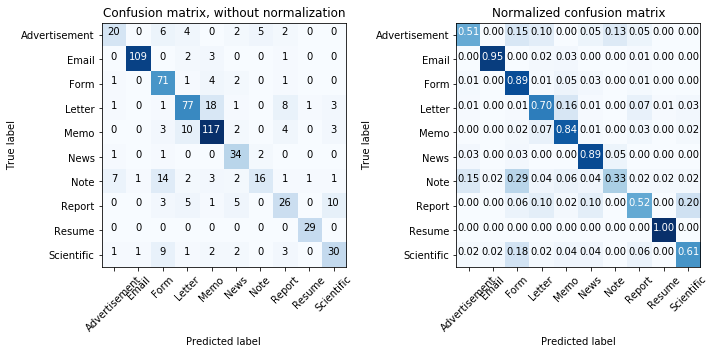

Test Accuracy: 0.7589670014347202


In [51]:
class_names = np.unique(true_labels)
conf_mat = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')
plt.show()
print("Test Accuracy:", accuracy_score(true_labels, pred_labels))

# Train word vectors with FastText Skipgram

In [62]:
tic = time()
model_skipgram = fasttext.skipgram('tobacco_nolabel.txt', 
                                   'ft_skipgram_100',
                                   min_count=1,
                                   dim=100,
                                   epoch=50,
                                   thread=16)
toc = time()
print(toc - tic)

50.85021424293518


# Neural network model for text classification

In [55]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of test examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index


def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix


def train_fit_predict(model, x_train, x_test, y_train, history):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


def plot_conf_mat(y_test, y_predicted):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [56]:
def evaluation(vectors_file_path, print_sum=True, plot_mat=True):
    embedding_index = get_embedding_index(vectors_file_path)
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    print('Building model...')
    model = get_model(embedding_matrix, word_index, print_sum=print_sum)
    history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)
    if plot_mat:
        plot_conf_mat(y_test, y_predicted)
    print("Test Accuracy:", accuracy_score(y_test, y_predicted))
    return accuracy_score(y_test, y_predicted)

In [84]:
base_data_dir = "data/Tobacco3482-OCR/"
list_dir = os.listdir(base_data_dir)
x = []
y = []
for repo in list_dir:
    prefix = base_data_dir + repo + '/'
    files = os.listdir(prefix)
    for file in files:
        with open(prefix + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(repo)
for i in range(len(x)):
    x[i] = x[i].replace('\n', ' ')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
vectors_file_path = 'ft_skipgram_100.vec'
with open('ft_skipgram_100.vec') as f:
    first_line = f.readline().split()

In [80]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 100
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

In [88]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, y_train, y_test)

Label categories: [0 1 2 3 4 5 6 7 8 9]
Converting data to trainable form...
Number of training examples: 2785
Number of test examples: 697


In [60]:
len(word_index)

75501

In [119]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    
    #model = Dropout(0.5)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Flatten()(model)
    model = LSTM(128, dropout=0.5, recurrent_dropout=0.3)(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

Found 155801 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 500, 100)          7372700   
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 500, 128)          38528     
_________________________________________________________________
dropout_38 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 250, 128)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 250, 64)           24640     
____________________________________________

2506/2506 [==============================] - 3s 1ms/step - loss: 0.3957 - acc: 0.8611 - val_loss: 0.5923 - val_acc: 0.8100
Epoch 47/100
2506/2506 [==============================] - 3s 1ms/step - loss: 0.3728 - acc: 0.8683 - val_loss: 0.5637 - val_acc: 0.8244
Epoch 48/100
2506/2506 [==============================] - 3s 1ms/step - loss: 0.3695 - acc: 0.8775 - val_loss: 0.6162 - val_acc: 0.7957
Epoch 49/100
2506/2506 [==============================] - 3s 1ms/step - loss: 0.3796 - acc: 0.8699 - val_loss: 0.5734 - val_acc: 0.8172
Epoch 50/100
2506/2506 [==============================] - 3s 1ms/step - loss: 0.3477 - acc: 0.8799 - val_loss: 0.6011 - val_acc: 0.8172
Epoch 51/100
2506/2506 [==============================] - 3s 1ms/step - loss: 0.3325 - acc: 0.8863 - val_loss: 0.5824 - val_acc: 0.8172
Epoch 52/100
2506/2506 [==============================] - 3s 1ms/step - loss: 0.3282 - acc: 0.8871 - val_loss: 0.7162 - val_acc: 0.7993
Epoch 53/100
2506/2506 [==============================] - 3s 

0.7890961262553802

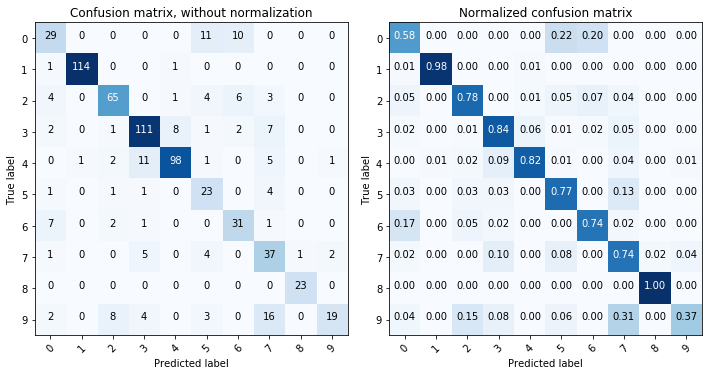

In [120]:
evaluation(vectors_file_path, print_sum=True, plot_mat=True)

In [87]:
# Model parameters
MAX_FEATURES = int(first_line[0])
MAX_TEXT_LENGTH = 500
EMBED_SIZE  = int(first_line[1])
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 0.1
CLASSES_LIST = np.unique(y_train)
NUM_CLASS = len(CLASSES_LIST)

Found 155801 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 500, 100)          7375100   
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 500, 128)          38528     
_________________________________________________________________
dropout_75 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 500, 64)           24640     
_________________________________________________________________
dropout_76 (Dropout)         (None, 500, 64)           0         
____________________________________________

Epoch 45/50
2506/2506 [==============================] - 0s 128us/step - loss: 0.1072 - acc: 0.9657 - val_loss: 1.0094 - val_acc: 0.7204
Epoch 46/50
2506/2506 [==============================] - 0s 129us/step - loss: 0.1197 - acc: 0.9601 - val_loss: 0.9682 - val_acc: 0.7599
Epoch 47/50
2506/2506 [==============================] - 0s 129us/step - loss: 0.1173 - acc: 0.9589 - val_loss: 0.9708 - val_acc: 0.7634
Epoch 48/50
2506/2506 [==============================] - 0s 129us/step - loss: 0.1234 - acc: 0.9565 - val_loss: 1.0035 - val_acc: 0.7312
Epoch 49/50
2506/2506 [==============================] - 0s 129us/step - loss: 0.1033 - acc: 0.9665 - val_loss: 0.9444 - val_acc: 0.7670
Epoch 50/50
2506/2506 [==============================] - 0s 129us/step - loss: 0.0958 - acc: 0.9729 - val_loss: 0.9552 - val_acc: 0.7527
Confusion matrix, without normalization
Normalized confusion matrix


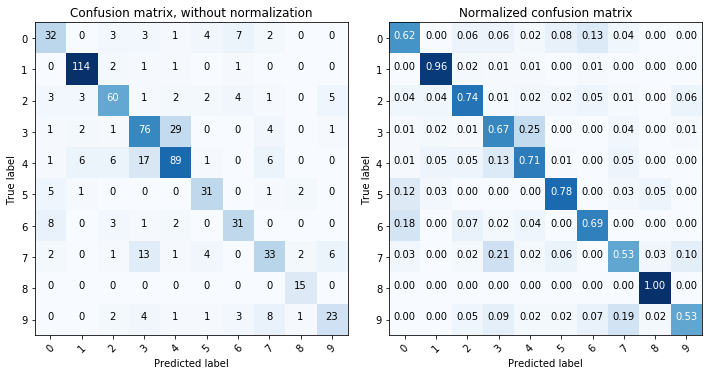

Test Accuracy: 0.7230989956958394


0.7230989956958394

In [89]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    #model = Dropout(0.5)(model)
    #model = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    #model = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    #model = LSTM(128, dropout=0.5, recurrent_dropout=0.3)(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NUM_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

evaluation(vectors_file_path, print_sum=True, plot_mat=True)